<a href="https://colab.research.google.com/github/c-c-c-c/100knocks/blob/master/SENet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>ディープラーニング入門</center>
## <center>Residual NetworksとSqueeze-and-Excitation Networks</center>

先端的なモデルを(Kerasで)実装するための技術を身につけるため、具体例としてSE-ResNetを取り上げます。

(一般的には、ここで学ぶモデルの実装技術に加えて、独自なlossの実装、複雑な学習手順の実装がさらに必要です。)

## 1. Functional APIを活用したSENetの実装

SENetの計算の流れは、部品に分ければ単純な層の集まりにすぎません。ですので丁寧に計算の流れを追えばすぐ実装できます。

ただしブロードキャスト積をする部分の操作に注意しましょう。keras.layers.Multiply()は、テンソルの要素積を行うLayerです（Numpy配列に対する`*`のようなもの）。

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

r = 16

input = layers.Input(shape=(32,32,3))

x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# SE block
z = layers.GlobalAveragePooling2D()(x)
z = layers.Dense(32//r, activation='relu')(z)
z = layers.Dense(32, activation='sigmoid')(z)
z = layers.Reshape((1,1, 32))(z)
x = layers.Multiply()([x, z])

x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# SE block
z = layers.GlobalAveragePooling2D()(x)
z = layers.Dense(64//r, activation='relu')(z)
z = layers.Dense(64, activation='sigmoid')(z)
z = layers.Reshape((1,1, 64))(z)
x = layers.Multiply()([x, z])

x = layers.Flatten()(x)

x = layers.Dropout(0.1)(x)
y = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=input, outputs=y)

model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 32, 32, 32)   896         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, 32, 32, 32)   128         conv2d_95[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 16, 16, 32)   0           batch_normalization_87[0][0]     
______________________________________________________________________________________

もう少しわかりやすいように、次のutilityを使って可視化しましょう：

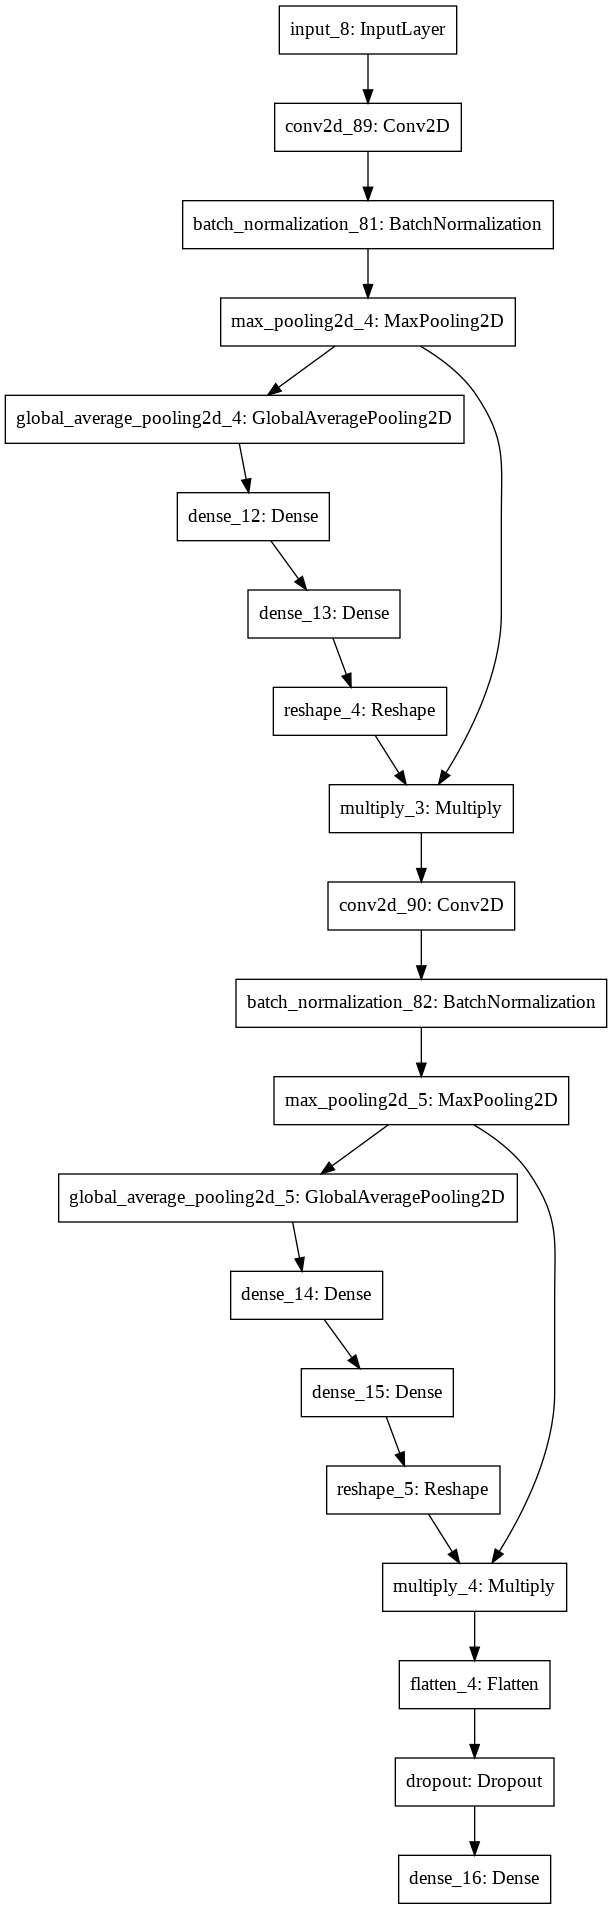

In [ ]:
from tensorflow.keras.utils import plot_model
import pydot

plot_model(model)

## 2. Layerクラスの継承によるSENetの実装

上のように毎回いちいちSEブロックのコードを書くのは面倒です。そこで他の層のように、SEブロックを一つのLayerクラスとして実装すると便利です。そのためにはkerasのLayerクラスを継承してサブクラスとして実装します：

https://keras.io/guides/making_new_layers_and_models_via_subclassing/

このあたりがまだ難しい人は、詳細は気にせず下の実装結果を使いましょう（ぜひPythonはクラスの扱いまでマスターしてください）。

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class SE_Block(layers.Layer):
    def __init__(self, reduction_ratio=16):
        super(SE_Block, self).__init__()
        self.r = reduction_ratio
  
    def build(self, input_shape):
        self.n_channels = input_shape[-1]
        self.bottle_neck = input_shape[-1]//self.r
        if self.bottle_neck < 1:
            raise ValueError(f"input channel {input_shape[-1]} divided by r = {self.r} must be greater than 0")
        self.gap = layers.GlobalAveragePooling2D()
        self.dense_1 = layers.Dense(self.bottle_neck, activation='relu')
        self.dense_2 = layers.Dense(self.n_channels, activation='sigmoid')
        self.reshape = layers.Reshape((1,1, self.n_channels))
        self.mult = layers.Multiply()

    def call(self, inputs):
        squeezed = self.gap(inputs)
        excited = self.dense_1(squeezed)
        excited = self.dense_2(excited)
        excited = self.reshape(excited)
        return self.mult([inputs, excited])

一度このサブクラスを実装すれば、あとは他の層と同様にこのクラスのインスタンスを層として使うだけです：

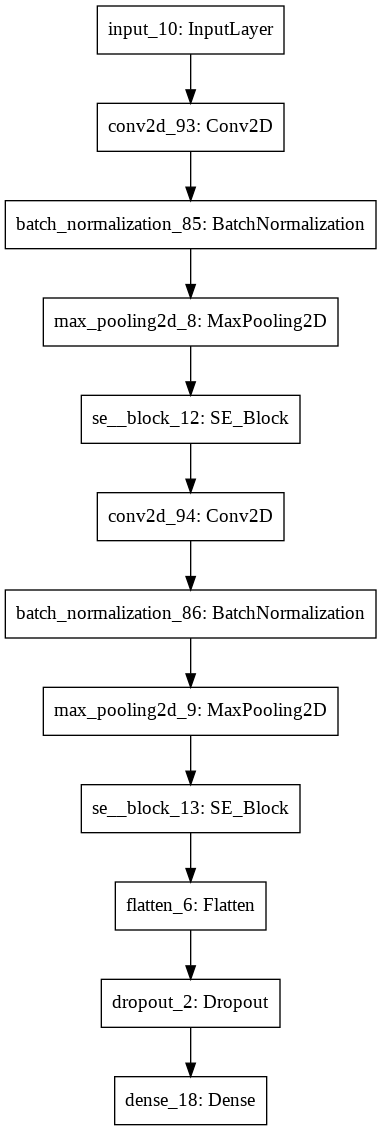

In [ ]:
input = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32), (3, 3), padding='same', activation='relu')(input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# SE block
x = SE_Block(r)(x)

x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# SE block
x = SE_Block(r)(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.1)(x)
y = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=input, outputs=y)

plot_model(model)

## 3. CIFAR10データセットを用いた学習実験

In [ ]:
from keras.datasets import cifar10
from keras.utils import np_utils
import numpy as np

(x_train,y_train),(x_test,y_test)=cifar10.load_data()

x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.

y_train=np_utils.to_categorical(y_train,10)
y_test=np_utils.to_categorical(y_test,10)

x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history=model.fit(x_train, y_train, batch_size=128, epochs=32, verbose=1, validation_split=0.1)

Epoch 1/32
352/352 [==============================] - 2s 7ms/step - loss: 1.3432 - accuracy: 0.5288 - val_loss: 1.6872 - val_accuracy: 0.3860
Epoch 2/32
352/352 [==============================] - 2s 6ms/step - loss: 0.9859 - accuracy: 0.6550 - val_loss: 0.9598 - val_accuracy: 0.6718
Epoch 3/32
352/352 [==============================] - 2s 6ms/step - loss: 0.8681 - accuracy: 0.6974 - val_loss: 0.9405 - val_accuracy: 0.6752
Epoch 4/32
352/352 [==============================] - 2s 6ms/step - loss: 0.7805 - accuracy: 0.7288 - val_loss: 0.9990 - val_accuracy: 0.6572
Epoch 5/32
352/352 [==============================] - 2s 6ms/step - loss: 0.7210 - accuracy: 0.7503 - val_loss: 0.9013 - val_accuracy: 0.6950
Epoch 6/32
352/352 [==============================] - 2s 6ms/step - loss: 0.6701 - accuracy: 0.7653 - val_loss: 0.8629 - val_accuracy: 0.7052
Epoch 7/32
352/352 [==============================] - 2s 6ms/step - loss: 0.6316 - accuracy: 0.7796 - val_loss: 0.9314 - val_accuracy: 0.6946
Epoch 

## 4. CIFAR10 datasetに対するResNet

https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py

から色々借りてきて実装。ResNetの原論文にあるように、CIFAR10とImageNetのモデルのデザインの細部は異なる。CIFAR10に関して報告されている性能は

|Model|n|200-epoch accuracy|Original paper accuracy |sec/epoch GTX1080Ti|
|:------------|--:|-------:|-----------------------:|---:|
|ResNet20   v1|  3| 92.16 %|                 91.25 %|35|
|ResNet32   v1|  5| 92.46 %|                 92.49 %|50|
|ResNet44   v1|  7| 92.50 %|                 92.83 %|70|
|ResNet56   v1|  9| 92.71 %|                 93.03 %|90|
|ResNet110  v1| 18| 92.65 %|            93.39+-.16 %|165|
|ResNet164  v1| 27|     - %|                 94.07 %|  -  |
|ResNet1001 v1|N/A|     - %|                 92.39 %|  -  |

ResNet v2は今回実装していないので、上のコードを参考に作って見ましょう。ちなみに上のリンクで報告されている性能は

Model|n|200-epoch accuracy|Original paper accuracy |sec/epoch GTX1080Ti
:------------|--:|-------:|-----------------------:|---:
ResNet20   v2|  2|     - %|                     - %|---
ResNet32   v2|N/A| NA    %|            NA         %| NA
ResNet44   v2|N/A| NA    %|            NA         %| NA
ResNet56   v2|  6| 93.01 %|            NA         %|100
ResNet110  v2| 12| 93.15 %|            93.63      %|180
ResNet164  v2| 18|     - %|            94.54      %|  -
ResNet1001 v2|111|     - %|            95.08+-.14 %|  -

今回使うベースモデルは

In [ ]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

model_type = 'ResNet%dv%d' % (depth, version)
print('model type', model_type)

model type ResNet20v1


SEブロックも組み込んだResNetの実装は以下のよう：
（多分大丈夫だと思いますが、骨格のResNetがちゃんと実装できているかチェックしてください）

In [ ]:
def conv_bn_relu(inputs, n_filters=16, kernel_size=3, strides=1, activation='relu', 
                 batch_normalization=True, post_activation=True):
    """
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        n_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        post_activation (bool): conv-bn-activation (True) or　bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = layers.Conv2D(n_filters, kernel_size=kernel_size, strides=strides, padding='same', 
                         kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    x = inputs
    if post_activation:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)

    return x


def residual_block(inputs, n_filters, down_sampling=False, first_stage=False, s_and_e=False):
    """
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        n_filters (int): number of filters
        down_sampling (bool): dowinsampling block or not
        first_stage (bool): block in first stage or not
        s_and_e (bool): use SE-ResNet or not
    # Returns
        x (tensor): tensor as input to the next block
    """
    x = inputs
    strides = 1
    if down_sampling and not first_stage:
      strides = 2
    z = conv_bn_relu(inputs=x, n_filters=n_filters, strides=strides) # bottleneck(S=2)
    z = conv_bn_relu(inputs=z, n_filters=n_filters, activation=None)
    if s_and_e:
        z = SE_Block(16)(z)
    if down_sampling and not first_stage:
        x = conv_bn_relu(inputs=x, n_filters=n_filters, kernel_size=1, strides=strides, 
                         activation=None, batch_normalization=False)
    x = layers.add([x, z])
    x = layers.Activation('relu')(x)

    return x

def stage(inputs, n_filters, n_res_blocks, first_stage=False, s_and_e=False):
    """
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        n_filters (int): number of filters
        n_res_blocks (int): number of residual block in the stage
        first_stage (bool): block in first stage or not
        s_and_e (bool): use SE-ResNet or not
    # Returns
        x (tensor): tensor as input to the next stage
    """
    x = inputs
    for res_block in range(n_res_blocks):
        down_sampling = (res_block == 0)
        x = residual_block(inputs=x, n_filters=n_filters, down_sampling=down_sampling, first_stage=first_stage, s_and_e=s_and_e)
    return x


def resnet_v1(input_shape, depth, n_classes=10, s_and_e=False):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [arXiv:1512.03385])')

    n_filters = 16
    n_res_blocks = int((depth - 2) / 6)

    inputs = layers.Input(shape=input_shape)
    x = conv_bn_relu(inputs=inputs)

    if s_and_e:
      x = SE_Block(16)(x)

    for s in range(3):
        first_stage = (s==0)
        x = stage(x, n_filters, n_res_blocks, first_stage=first_stage, s_and_e=s_and_e)
        n_filters *= 2

    # v1 does not use BN after last shortcut connection-ReLU
    x = layers.AveragePooling2D(pool_size=8)(x)
    y = layers.Flatten()(x)
    outputs = layers.Dense(n_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

SEバージョンのモデルインスタンスを作るには、`s_and_e`引数に`True`を渡してください：

In [ ]:
model = resnet_v1((32,32,3) , depth, n_classes=10, s_and_e=True)

学習率のスケジューリング：

In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

データ水増しと学習

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [lr_scheduler]

datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

datagen.fit(x_train)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                        validation_data=(x_test, y_test),
                        epochs=128, verbose=1, #workers=4,
                        callbacks=callbacks)

Learning rate:  0.001
Instructions for updating:
Please use Model.fit, which supports generators.
Learning rate:  0.001
Epoch 1/128
1563/1563 [==============================] - 39s 25ms/step - loss: 1.5679 - accuracy: 0.4803 - val_loss: 1.9819 - val_accuracy: 0.4302
Learning rate:  0.001
Epoch 2/128
1563/1563 [==============================] - 38s 24ms/step - loss: 1.1896 - accuracy: 0.6293 - val_loss: 1.2671 - val_accuracy: 0.6033
Learning rate:  0.001
Epoch 3/128
1563/1563 [==============================] - 38s 24ms/step - loss: 1.0284 - accuracy: 0.6900 - val_loss: 1.1625 - val_accuracy: 0.6500
Learning rate:  0.001
Epoch 4/128
1563/1563 [==============================] - 38s 25ms/step - loss: 0.9227 - accuracy: 0.7279 - val_loss: 1.0884 - val_accuracy: 0.6836
Learning rate:  0.001
Epoch 5/128
1563/1563 [==============================] - 38s 24ms/step - loss: 0.8557 - accuracy: 0.7558 - val_loss: 1.2561 - val_accuracy: 0.6360
Learning rate:  0.001
Epoch 6/128
1563/1563 [============

一方でSEブロックを入れない場合は

In [ ]:
model = resnet_v1((32,32,3) , depth, num_classes=10, s_and_e=False)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                        validation_data=(x_test, y_test),
                        epochs=128, verbose=1, #workers=4,
                        callbacks=callbacks)

Learning rate:  0.001
Learning rate:  0.001
Epoch 1/128
1563/1563 [==============================] - 33s 21ms/step - loss: 1.5719 - accuracy: 0.4892 - val_loss: 1.4245 - val_accuracy: 0.5537
Learning rate:  0.001
Epoch 2/128
1563/1563 [==============================] - 33s 21ms/step - loss: 1.1794 - accuracy: 0.6370 - val_loss: 1.1371 - val_accuracy: 0.6489
Learning rate:  0.001
Epoch 3/128
1563/1563 [==============================] - 32s 21ms/step - loss: 1.0148 - accuracy: 0.7002 - val_loss: 1.3249 - val_accuracy: 0.6289
Learning rate:  0.001
Epoch 4/128
1563/1563 [==============================] - 32s 21ms/step - loss: 0.9148 - accuracy: 0.7353 - val_loss: 1.2616 - val_accuracy: 0.6518
Learning rate:  0.001
Epoch 5/128
1563/1563 [==============================] - 33s 21ms/step - loss: 0.8507 - accuracy: 0.7630 - val_loss: 1.3827 - val_accuracy: 0.6351
Learning rate:  0.001
Epoch 6/128
1563/1563 [==============================] - 32s 21ms/step - loss: 0.8118 - accuracy: 0.7767 - val_

この実験では若干性能がいいかも、くらいの差（統計をためる必要）。もっと深いモデルで200epoch性能で比べると良いかも。